# Import

In [ ]:
pip install --upgrade konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 26.2 MB/s eta 0:00:00


In [ ]:
!pip3 install "pandas<2.0.0"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
os.environ["PYTHONIOENCODING"] = "utf-8"
from konlpy.tag import Kkma, Okt, Komoran
from wordcloud import WordCloud
import re
import matplotlib
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from konlpy.tag import Kkma, Okt, Komoran
from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import statistics
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/KUBIG_WinterPR/클로바 Output/클로바_최종 Output.csv', encoding = 'utf-8')

In [ ]:
df.head(6)

시장                                    content sentiment  \
0  남대문시장   단순한 대중시장…\n경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.   neutral   
1  남대문시장  처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.   neutral   
2  남대문시장                              2층에 위치해 있습니다.   neutral   
3  남대문시장                   \n결국 팔찌를 몇 개 더 구입하게 됐어요.   neutral   
4  남대문시장                           내 친구는 그것을 좋아합니다.  positive   
5  남대문시장                  \n여행자에게 이곳을 방문하는 것이 좋습니다.   neutral   

                                          confidence  
0  {'negative': 0.0002609231, 'positive': 0.00095...  
1  {'negative': 4.258405e-05, 'positive': 0.00028...  
2  {'negative': 1.4997657e-05, 'positive': 1.5647...  
3  {'negative': 5.965026e-05, 'positive': 0.00045...  
4  {'negative': 0.0003658994, 'positive': 0.99413...  
5  {'negative': 1.375222e-05, 'positive': 3.31152...

In [ ]:
df['sentiment'].value_counts().sort_index()

negative     361
neutral      955
positive    1638
Name: sentiment, dtype: int64

# EDA

## 결측치 확인

In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(df)

결측치가 존재하지 않습니다


## sentiment_idx 빈도수

In [ ]:
# sentiment_idx 빈도수
print(df['sentiment'].value_counts())
sns.countplot(data = df, x = 'sentiment', order = df['sentiment'].value_counts().index)

positive    1638
neutral      955
negative     361
Name: sentiment, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

## 단어빈도수
- \n, \t, \r 등 전처리

In [ ]:
# 단어 빈도수
df['len'] = df['content'].apply(lambda x: len(x))
df['word_cnt'] = df['content'].apply(lambda x: len(x.split()))
df.head()

시장                                    content sentiment  \
0  남대문시장   단순한 대중시장…\n경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.   neutral   
1  남대문시장  처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.   neutral   
2  남대문시장                              2층에 위치해 있습니다.   neutral   
3  남대문시장                   \n결국 팔찌를 몇 개 더 구입하게 됐어요.   neutral   
4  남대문시장                           내 친구는 그것을 좋아합니다.  positive   

                                          confidence  len  word_cnt  
0  {'negative': 0.0002609231, 'positive': 0.00095...   39         9  
1  {'negative': 4.258405e-05, 'positive': 0.00028...   41        10  
2  {'negative': 1.4997657e-05, 'positive': 1.5647...   13         3  
3  {'negative': 5.965026e-05, 'positive': 0.00045...   23         7  
4  {'negative': 0.0003658994, 'positive': 0.99413...   16         4

In [ ]:
df["content"]

0        단순한 대중시장…\n경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.
1       처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.
2                                   2층에 위치해 있습니다.
3                        \n결국 팔찌를 몇 개 더 구입하게 됐어요.
4                                내 친구는 그것을 좋아합니다.
                          ...                    
2949                                          좋아요
2950                                            굿
2951                                          좋아요
2952                                 좋아요~~~~~~~~~
2953                                          좋아요
Name: content, Length: 2954, dtype: object

In [ ]:
def remove_newline(text):
    return text.replace('\n', '').replace('\t','').replace('\r','')

# 'content' 안에  '\n'가 있다면 제거
df['content'] = df['content'].apply(remove_newline)

In [ ]:
df["content"]

0          단순한 대중시장…경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.
1       처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.
2                                   2층에 위치해 있습니다.
3                          결국 팔찌를 몇 개 더 구입하게 됐어요.
4                                내 친구는 그것을 좋아합니다.
                          ...                    
2949                                          좋아요
2950                                            굿
2951                                          좋아요
2952                                 좋아요~~~~~~~~~
2953                                          좋아요
Name: content, Length: 2954, dtype: object

## 문장 길이

In [ ]:
# 문장 길이
sns.displot(data = df, x = "len", hue = "sentiment", col = "sentiment",
            col_wrap = 2, height = 5, aspect = 5)

#Preprocessing

## 품사 태깅 및 어간 추출
- kkma
- okt
- komoran

In [ ]:
kkma = Kkma()
okt = Okt()
komoran = Komoran()

In [ ]:
## 세가지 형태소 분석기 kkma, okt, komoran overview
## 결과를 보아 kkma, okt로 다시한번 구현

for i in range(5):
  text = df['content'][i]

  kkma_result = kkma.pos(text)
  okt_result = okt.pos(text)
  komoran_result = komoran.pos(text)

  print("kkma    : ", kkma_result)
  print("okt     : ", okt_result)
  print("komoran : ", komoran_result)
  print('\n')

kkma    :  [('단순', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('대중', 'NNG'), ('시장', 'NNG'), ('…', 'SE'), ('경쟁력', 'NNG'), ('있', 'VV'), ('는', 'ETD'), ('가격', 'NNG'), ('으로', 'JKM'), ('많', 'VA'), ('은', 'ETD'), ('상품', 'NNG'), ('이', 'JKS'), ('포함', 'NNG'), ('되', 'XSV'), ('어', 'ECD'), ('있', 'VXV'), ('습니다', 'EFN'), ('.', 'SF')]
okt     :  [('단순한', 'Adjective'), ('대중시', 'Noun'), ('장', 'Suffix'), ('…', 'Punctuation'), ('경쟁력', 'Noun'), ('있는', 'Adjective'), ('가격', 'Noun'), ('으로', 'Josa'), ('많은', 'Adjective'), ('상품', 'Noun'), ('이', 'Josa'), ('포함', 'Noun'), ('되어', 'Verb'), ('있습니다', 'Adjective'), ('.', 'Punctuation')]
komoran :  [('단순', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM'), ('대중', 'NNP'), ('시장', 'NNP'), ('…', 'SE'), ('경쟁력', 'NNP'), ('있', 'VV'), ('는', 'ETM'), ('가격', 'NNG'), ('으로', 'JKB'), ('많', 'VA'), ('은', 'ETM'), ('상품', 'NNG'), ('이', 'JKS'), ('포함', 'NNG'), ('되', 'XSV'), ('어', 'EC'), ('있', 'VX'), ('습니다', 'EF'), ('.', 'SF')]


kkma    :  [('처음', 'NNG'), ('으로', 'JKM'), ('보석', 'NNG'), ('도매점', 'NNG'), ('을', 'JKO'), 

### Kkma
- 다른 형태소 분석기에 비해 시간은 다소 소요되지만, 다양한 품사를 제공
- 태그표 : http://kkma.snu.ac.kr/documents/?doc=postag
- 어간추출에 효율적이나, 동사 정제가 따로 필요해 보여 okt사용

In [ ]:
# 접미사, 어미, 부호, 조사, 동사(이다, 아니다), 의존명사
no_token = ["XSN", "XSV","XSA",
            "EPH","EPT","EPP","EFN","EFQ","EFO",'EFA','EFI','EFR','ECE','ECD','ECS','ETN','ETD',
            "SF",'SP','SS','SE','SO','SW',
            "JKS","JKC",'JKG','JKO','JKM','JKI','JKQ','JX','JC',
            "VCP",'VCN',
            "NNB","NNM"]

def pos_cleaner_kkma(text):
    result = []
    kkma = Kkma()
    try:
        for s in kkma.pos(text):
            if s[1] not in no_token:
                result.append(s[0])

    except UnicodeDecodeError:
        only_BMP_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
                           "]+", flags=re.UNICODE) # https://studyprogram.tistory.com/1 참고
        text = only_BMP_pattern.sub(r'', text)
        if text == ' ': text = '' # 공백의 텍스트일 경우 java.lang.NullPointerException 발생 -> 빈문자열로 처리
        for s in kkma.pos(text):
            if s[1] not in no_token:
                result.append(s[0])

    return " ".join(result)

### Okt
- 속도면에서 다른 형태소 분석기보다 성능이 좋음
- kkma보다는 품사가 다양하지 않음

In [ ]:
# okt
def pos_cleaner(str):
  result = []
  for s in okt.pos(str, stem=True):
    # 관형사, 조사, 어미, 구두점, 접미사, 한국어 자음-모음 을 제외한 나머지 품사는 결과에 넣어줌
    if s[1] not in ["Determiner", "Josa", "Emoi", "Punctuation", "Suffix", "KoreanParticle"]:
      result.append(s[0])
  return " ".join(result)

## 데이터 정제

In [ ]:
## 품사 태깅으로 처리되지 않은 기타 기본적인 텍스트 정제

def text_preprocessor(s):
    import re

    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)

    ## (2) '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')

    ## (3) 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')

    ## (5) 특수문자 제거
    pattern = r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-z]'
    s = re.sub(pattern=pattern, repl=' ', string=s)

    return s

## 불용어 처리

In [ ]:
## 구글링으로 긁어온 한국어 전처리에 자주 사용되는 불용어 모음

stop_words = "이다 매우 너무 되어다 싶다 아주 없이 유시 아 종합 년 월 일 원 조원 억원 더 일 십 백 천 만 조 억 개 보 것 수 데 첫 국 개국 안 하다 등 외 못 안 달 의 후 전 우리 분 그리고 및 그 제 더 하는 한다 없 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_words = stop_words.split(' ')

def del_stop_words(s):
  seq = s.split(' ')
  result = []
  for w in seq:
      if w not in stop_words:
        if len(w) != 1:
          result.append(w)
  return ' '.join(result)

In [ ]:
df["clean_content"] = df["content"].apply(lambda x: pos_cleaner(x))
# df["clean_content"] = df["content"].apply(lambda x: pos_cleaner_kkma(x))
df["clean_content"] = df["clean_content"].apply(lambda x: text_preprocessor(x))
df["clean_content"] = df["clean_content"].apply(lambda x: del_stop_words(x))

df.head(10)

시장                                    content sentiment  \
0  남대문시장     단순한 대중시장…경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.   neutral   
1  남대문시장  처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.   neutral   
2  남대문시장                              2층에 위치해 있습니다.   neutral   
3  남대문시장                     결국 팔찌를 몇 개 더 구입하게 됐어요.   neutral   
4  남대문시장                           내 친구는 그것을 좋아합니다.  positive   
5  남대문시장                    여행자에게 이곳을 방문하는 것이 좋습니다.   neutral   
6  남대문시장                          작은 선물을 찾는 데 좋습니다.  positive   
7  남대문시장             동일한 제품에 대해 가격이 다른 매장 간 중복이 많다.   neutral   
8  남대문시장                      관광객이 많은 비교적 민간인 쇼핑 거리   neutral   
9  남대문시장                           엄청난 물건을 팔고 있습니다.   neutral   

                                          confidence  \
0  {'negative': 0.0002609231, 'positive': 0.00095...   
1  {'negative': 4.258405e-05, 'positive': 0.00028...   
2  {'negative': 1.4997657e-05, 'positive': 1.5647...   
3  {'negative': 5.965026e-05, 'positive': 0.00045...   
4  {'negative': 0.0003658994, 'positive': 0.99413...   
5  {'negative': 1.375222e-05, 'positive': 3.31152...   
6  {'negative': 0.0002066826, 'positive': 0.99938...   
7  {'negative': 0.0009400268, 'positive': 0.00018...   
8  {'negative': 0.00018030022, 'positive': 0.0002...   
9  {'negative': 1.7695229e-05, 'positive': 6.3086...   

              clean_content                           content_list  
0  단순하다 대중시 경쟁력 가격 많다 상품 포함  [단순하다, 대중시, 경쟁력, 가격, 많다, 상품, 포함, 되어다]  
1     처음 보석 매점 방문 정말 번쩍 뜨이다      [처음, 보석, 매점, 방문, 정말, 번쩍, 뜨이다, 이다]  
2                        위치                                   [위치]  
3                  팔찌 구입 돼다                           [팔찌, 구입, 돼다]  
4                   친구 좋아하다                             [친구, 좋아하다]  
5                 여행자 방문 좋다                          [여행자, 방문, 좋다]  
6               작다 선물 찾다 좋다                       [작다, 선물, 찾다, 좋다]  
7       동일하다 제품 가격 매장 중복 많다             [동일하다, 제품, 가격, 매장, 중복, 많다]  
8       관광객 많다 비교 민간인 쇼핑 거리             [관광객, 많다, 비교, 민간인, 쇼핑, 거리]  
9                엄청나다 물건 팔고                         [엄청나다, 물건, 팔고]

In [ ]:
# wordcloud 및 정수 인코딩용 데이터프레임
def text_to_seq(s):
  seq = s.split(' ')
  seq = list(filter(None, seq))
  return seq

df["content_list"] = df["clean_content"].apply(lambda x : text_to_seq(x))
df.head(10)

시장                                    content sentiment  \
0  남대문시장     단순한 대중시장…경쟁력 있는 가격으로 많은 상품이 포함되어 있습니다.   neutral   
1  남대문시장  처음으로 보석 도매점을 방문하는 것은 정말 눈이 번쩍 뜨이는 일이었습니다.   neutral   
2  남대문시장                              2층에 위치해 있습니다.   neutral   
3  남대문시장                     결국 팔찌를 몇 개 더 구입하게 됐어요.   neutral   
4  남대문시장                           내 친구는 그것을 좋아합니다.  positive   
5  남대문시장                    여행자에게 이곳을 방문하는 것이 좋습니다.   neutral   
6  남대문시장                          작은 선물을 찾는 데 좋습니다.  positive   
7  남대문시장             동일한 제품에 대해 가격이 다른 매장 간 중복이 많다.   neutral   
8  남대문시장                      관광객이 많은 비교적 민간인 쇼핑 거리   neutral   
9  남대문시장                           엄청난 물건을 팔고 있습니다.   neutral   

                                          confidence  \
0  {'negative': 0.0002609231, 'positive': 0.00095...   
1  {'negative': 4.258405e-05, 'positive': 0.00028...   
2  {'negative': 1.4997657e-05, 'positive': 1.5647...   
3  {'negative': 5.965026e-05, 'positive': 0.00045...   
4  {'negative': 0.0003658994, 'positive': 0.99413...   
5  {'negative': 1.375222e-05, 'positive': 3.31152...   
6  {'negative': 0.0002066826, 'positive': 0.99938...   
7  {'negative': 0.0009400268, 'positive': 0.00018...   
8  {'negative': 0.00018030022, 'positive': 0.0002...   
9  {'negative': 1.7695229e-05, 'positive': 6.3086...   

                  clean_content                           content_list  
0  단순하다 대중시 경쟁력 가격 많다 상품 포함 되어다  [단순하다, 대중시, 경쟁력, 가격, 많다, 상품, 포함, 되어다]  
1      처음 보석 매점 방문 정말 번쩍 뜨이다 이다      [처음, 보석, 매점, 방문, 정말, 번쩍, 뜨이다, 이다]  
2                            위치                                   [위치]  
3                      팔찌 구입 돼다                           [팔찌, 구입, 돼다]  
4                       친구 좋아하다                             [친구, 좋아하다]  
5                     여행자 방문 좋다                          [여행자, 방문, 좋다]  
6                   작다 선물 찾다 좋다                       [작다, 선물, 찾다, 좋다]  
7           동일하다 제품 가격 매장 중복 많다             [동일하다, 제품, 가격, 매장, 중복, 많다]  
8           관광객 많다 비교 민간인 쇼핑 거리             [관광객, 많다, 비교, 민간인, 쇼핑, 거리]  
9                    엄청나다 물건 팔고                         [엄청나다, 물건, 팔고]

# WordCloud

## 전체적인 긍부정/중립 단어 빈도수
- neutral
- positive
- negative

In [ ]:
from collections import Counter

A = ['neutral', 'positive', 'negative']

for sentiment in A:
    result = []
    content_list = df[df["sentiment"] == sentiment]["content_list"]

    for seq in content_list:
        for s in seq:
            result.append(s)

    globals()['tags_%s' % sentiment] = Counter(result).most_common(40)
    globals()['tags_keys_%s' % sentiment] = [key for key, _ in Counter(result).most_common(20)]

print(tags_neutral)
print(tags_positive)
print(tags_negative)


[('시장', 144), ('많다', 102), ('이다', 76), ('보다', 57), ('가다', 51), ('먹다', 46), ('음식', 42), ('방문', 39), ('많이', 35), ('가게', 28), ('오다', 27), ('과일', 27), ('좋다', 26), ('한국', 26), ('가격', 23), ('찾다', 23), ('서울', 23), ('구경', 23), ('물건', 22), ('구입', 21), ('전통', 21), ('구매', 20), ('다양하다', 20), ('싶다', 19), ('크다', 19), ('쇼핑', 18), ('야채', 18), ('망원', 18), ('거리', 16), ('사르다', 16), ('가보다', 16), ('모든', 15), ('들다', 15), ('다녀오다', 14), ('대부분', 14), ('팔다', 14), ('노점', 14), ('재래시장', 14), ('튀김', 14), ('동시', 14)]
[('좋다', 547), ('시장', 181), ('저렴하다', 161), ('많다', 158), ('맛있다', 157), ('가격', 92), ('이다', 90), ('싸다', 90), ('다양하다', 82), ('음식', 77), ('물건', 72), ('먹다', 63), ('과일', 63), ('친절하다', 56), ('너무', 54), ('먹거리', 48), ('매우', 43), ('정말', 42), ('쇼핑', 40), ('보다', 37), ('최고', 36), ('재래시장', 35), ('구경', 33), ('싱싱하다', 31), ('신선하다', 31), ('많이', 29), ('장소', 28), ('추천', 28), ('야채', 28), ('거리', 27), ('튀김', 27), ('즐겁다', 26), ('현지', 25), ('모든', 25), ('볼거리', 25), ('크다', 25), ('구매', 24), ('구입', 24), ('방문', 24), ('되어다', 23)]
[('많다

In [ ]:
print("Top words in tags_neutral:")
for word, count in tags_neutral:
    print(f"{word}: {count}")


Top words in tags_neutral:
시장: 144
많다: 102
이다: 76
보다: 57
가다: 51
먹다: 46
음식: 42
방문: 39
많이: 35
가게: 28
오다: 27
과일: 27
좋다: 26
한국: 26
가격: 23
찾다: 23
서울: 23
구경: 23
물건: 22
구입: 21
전통: 21
구매: 20
다양하다: 20
싶다: 19
크다: 19
쇼핑: 18
야채: 18
망원: 18
거리: 16
사르다: 16
가보다: 16
모든: 15
들다: 15
다녀오다: 14
대부분: 14
팔다: 14
노점: 14
재래시장: 14
튀김: 14
동시: 14


In [ ]:
print("Top words in tags_positive:")
for word, count in tags_positive:
    print(f"{word}: {count}")


Top words in tags_positive:
좋다: 547
시장: 181
저렴하다: 161
많다: 158
맛있다: 157
가격: 92
이다: 90
싸다: 90
다양하다: 82
음식: 77
물건: 72
먹다: 63
과일: 63
친절하다: 56
너무: 54
먹거리: 48
매우: 43
정말: 42
쇼핑: 40
보다: 37
최고: 36
재래시장: 35
구경: 33
싱싱하다: 31
신선하다: 31
많이: 29
장소: 28
추천: 28
야채: 28
거리: 27
튀김: 27
즐겁다: 26
현지: 25
모든: 25
볼거리: 25
크다: 25
구매: 24
구입: 24
방문: 24
되어다: 23


In [ ]:
print("Top words in tags_negative:")
for word, count in tags_negative:
    print(f"{word}: {count}")


Top words in tags_negative:
많다: 43
시장: 41
너무: 39
가격: 31
비싸다: 23
주차: 20
이다: 18
좋다: 15
가다: 15
불편하다: 14
별로: 13
오다: 13
그냥: 12
상인: 11
아쉽다: 11
매우: 11
힘들다: 11
복잡하다: 11
과일: 11
그렇다: 11
주차장: 11
저렴하다: 10
구입: 10
불친절하다: 10
가게: 9
상품: 9
보다: 9
싸다: 9
먹다: 9
닫다: 8
물건: 8
자다: 8
냄새: 8
받다: 8
어렵다: 8
정말: 8
관광객: 8
모르다: 7
말다: 7
조심하다: 7


## Wordcloud

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from wordcloud import WordCloud

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
FONT_PATH = "/content/drive/MyDrive/KUBIG_WinterPR/NanumSquareB.ttf"
plt.rc('font', family=FONT_PATH)

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

### 시장별 워드클라우드

[('좋다', 85), ('시장', 53), ('많다', 36), ('쇼핑', 28), ('음식', 27), ('저렴하다', 26), ('가격', 24), ('찾다', 20), ('맛있다', 20), ('물건', 18), ('방문', 17), ('기념품', 16), ('한국', 16), ('먹다', 15), ('모든', 15), ('구입', 14), ('싸다', 14), ('현지', 12), ('즐겁다', 11), ('장소', 11), ('서울', 11), ('상점', 11), ('친절하다', 10), ('의류', 10), ('상품', 9), ('길거리', 9), ('구매', 9), ('갈치', 9), ('제품', 8), ('경험', 8), ('말다', 8), ('거리', 7), ('아침', 7), ('가게', 7), ('제공', 7), ('추천', 7), ('안경', 7), ('다양하다', 7), ('재미', 7), ('조림', 7)]
[('좋다', 57), ('시장', 41), ('많다', 39), ('저렴하다', 22), ('재래시장', 21), ('가격', 18), ('다양하다', 18), ('주차', 16), ('먹거리', 16), ('크다', 15), ('수유', 13), ('물건', 12), ('가게', 11), ('맛있다', 10), ('친절하다', 8), ('구경', 7), ('전통', 7), ('먹다', 7), ('살다', 7), ('장보기', 7), ('주차장', 7), ('싱싱하다', 6), ('종류', 6), ('싸다', 6), ('상인', 5), ('김치', 5), ('튀김', 5), ('쇼핑', 5), ('반찬', 5), ('구매', 5), ('야채', 5), ('생선', 5), ('손님', 4), ('거리', 4), ('이용', 4), ('이벤트', 4), ('마트', 4), ('족발', 4), ('비싸다', 4), ('홍어', 4)]
[('과일', 59), ('좋다', 50), ('시장', 43), ('저렴하다', 42), ('가

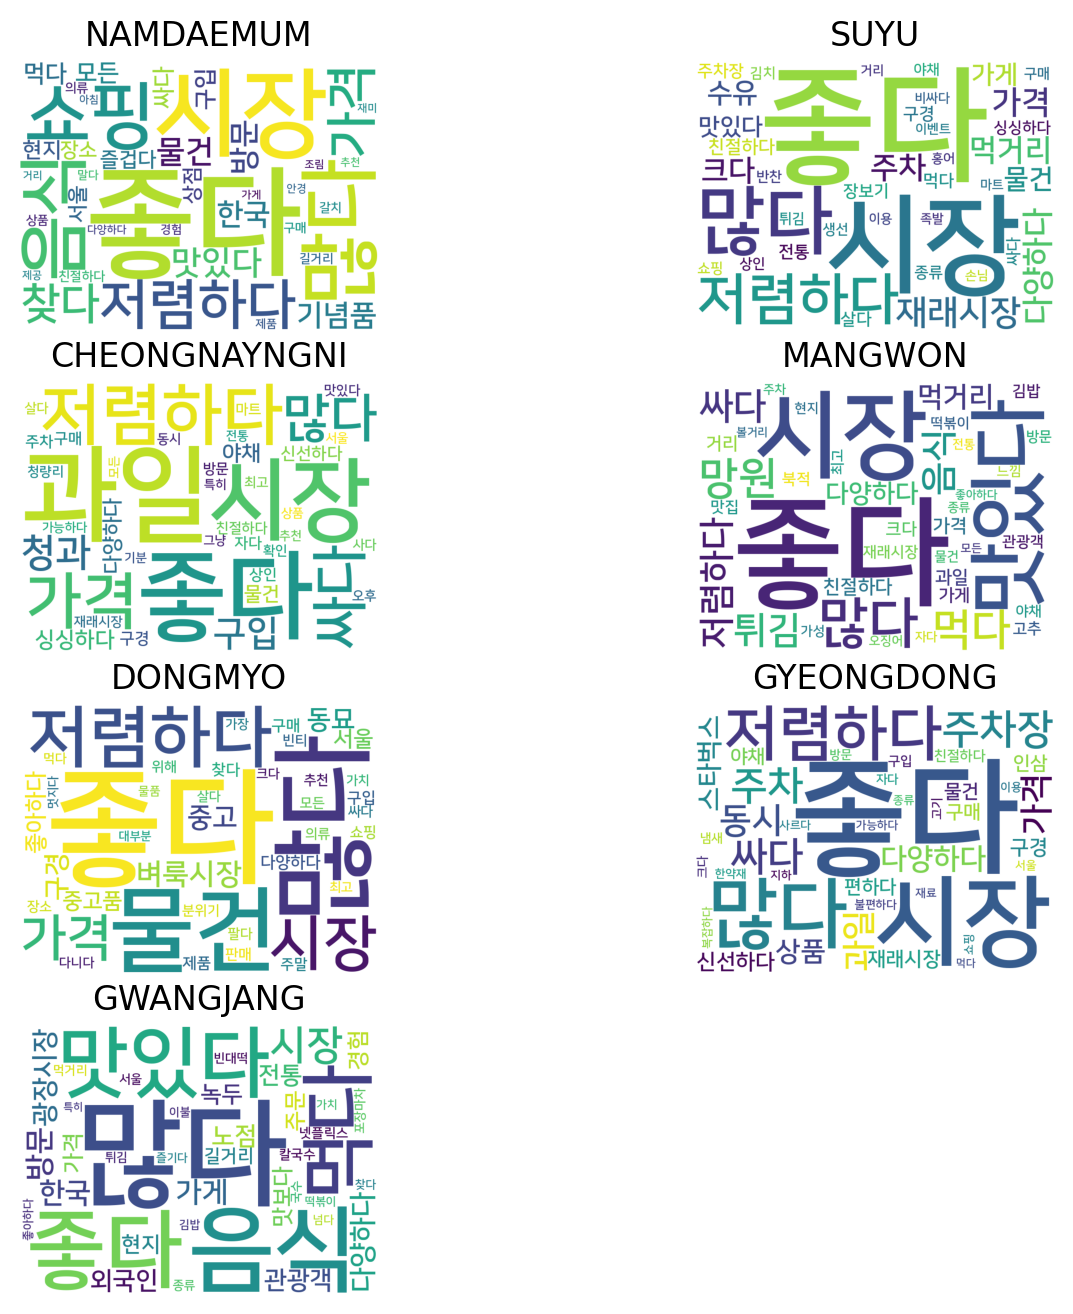

In [ ]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
stop_wds = ['이다', '매우', '너무', '되어다', '싶다', '아주', '없이', '유시', '보다','다녀오다','가다','오다','정말','가보다','들다','많이']

for idx, market in enumerate(df['시장'].unique()):
  result = []
  title_list = df[(df['시장'] == market)]['content_list']
  for seq in title_list:
    for s in seq:
        if s not in stop_wds:
            result.append(s)

  globals()['tags_%d'%idx] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%idx] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('NAMDAEMUM')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('SUYU')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('CHEONGNAYNGNI')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('MANGWON')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('DONGMYO')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('GYEONGDONG')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('GWANGJANG')


plt.show()

### 시장별 긍정워드클라우드

[('좋다', 80), ('시장', 31), ('저렴하다', 24), ('쇼핑', 22), ('많다', 18), ('맛있다', 18), ('가격', 14), ('싸다', 12), ('음식', 11), ('찾다', 10), ('즐겁다', 10), ('친절하다', 10), ('기념품', 10), ('현지', 10), ('물건', 10), ('장소', 9), ('먹다', 8), ('모든', 7), ('안경', 7), ('구매', 6), ('제품', 6), ('다양하다', 6), ('훌륭하다', 6), ('재미', 6), ('제공', 5), ('괜찮다', 5), ('멋지다', 5), ('의류', 5), ('구입', 5), ('활기차다', 5), ('아줌마', 4), ('즐기다', 4), ('서울', 4), ('경험', 4), ('추천', 4), ('보석', 4), ('예쁘다', 4), ('볼거리', 4), ('상품', 4), ('품질', 4)]
[('좋다', 55), ('많다', 26), ('저렴하다', 20), ('시장', 17), ('다양하다', 15), ('가격', 14), ('먹거리', 14), ('재래시장', 14), ('맛있다', 10), ('물건', 9), ('친절하다', 8), ('주차', 8), ('크다', 8), ('싱싱하다', 6), ('구경', 6), ('싸다', 6), ('장보기', 6), ('종류', 5), ('야채', 5), ('생선', 5), ('수유', 5), ('먹다', 4), ('거리', 4), ('이용', 4), ('살다', 4), ('가게', 4), ('주차장', 4), ('깨끗하다', 3), ('편하다', 3), ('마트', 3), ('김치', 3), ('깔끔하다', 3), ('활기', 3), ('볼거리', 3), ('반찬', 3), ('주변', 3), ('가깝다', 3), ('고기', 3), ('최고', 3), ('항상', 3)]
[('좋다', 42), ('저렴하다', 39), ('과일', 36), ('가격', 24), ('싸

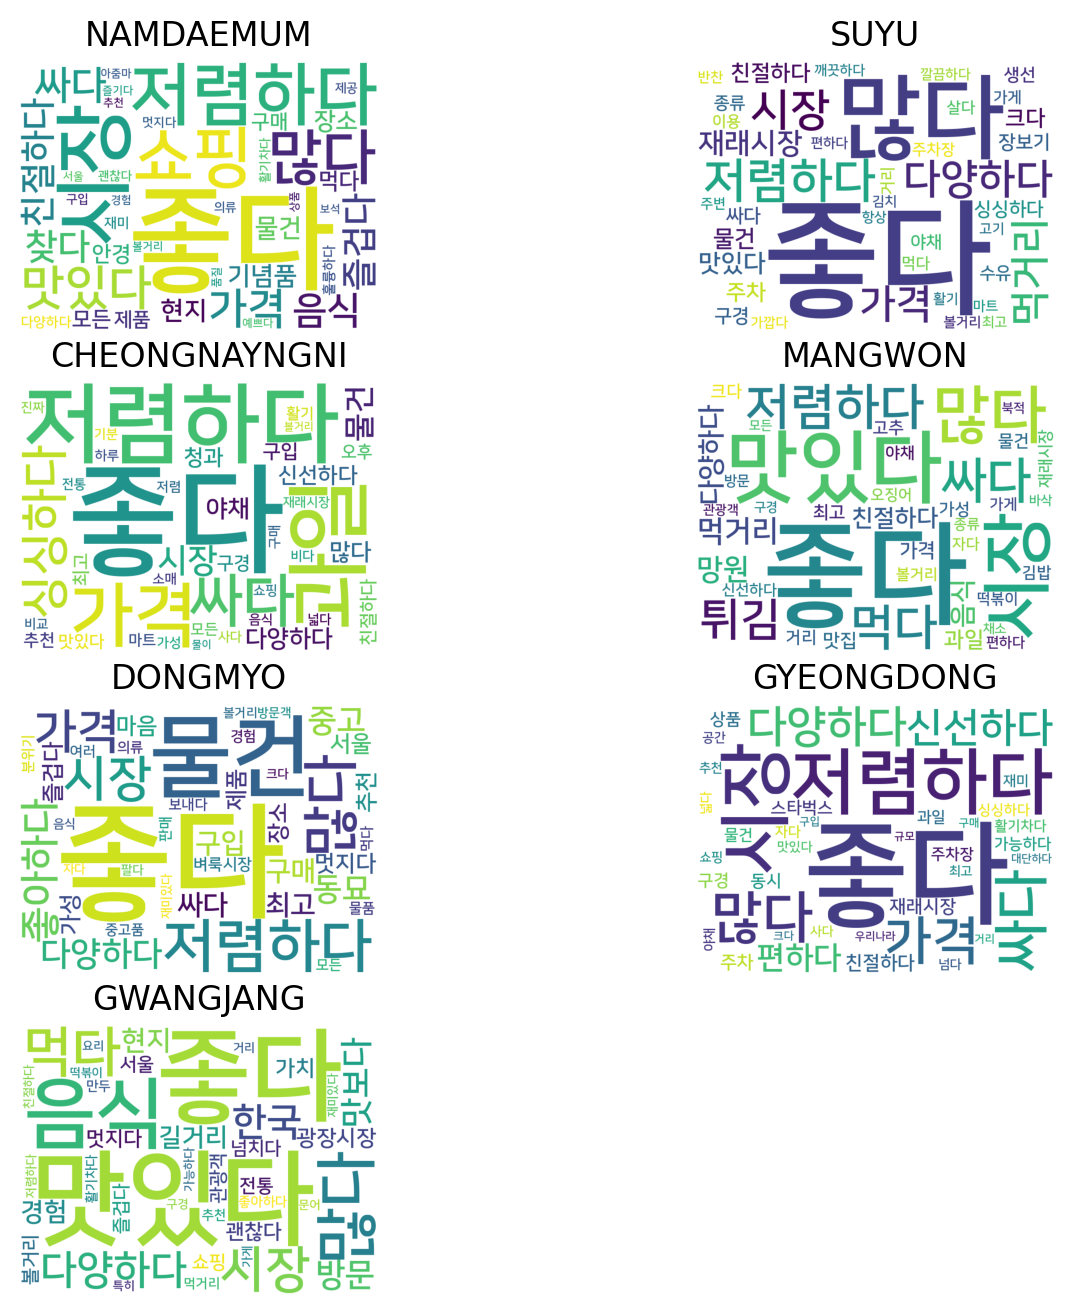

In [ ]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
stop_wds = ['이다', '매우', '너무', '되어다', '싶다', '아주', '없이', '유시', '보다','다녀오다','가다','오다','정말','가보다','들다','많이']

for idx, market in enumerate(df['시장'].unique()):
  result = []
  title_list = df[(df['시장']==market)&(df['sentiment']=='positive')]['content_list']
  for seq in title_list:
    for s in seq:
        if s not in stop_wds:
            result.append(s)

  globals()['tags_%d'%idx] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%idx] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('NAMDAEMUM')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('SUYU')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('CHEONGNAYNGNI')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('MANGWON')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('DONGMYO')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('GYEONGDONG')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('GWANGJANG')


plt.show()

## '종합' 같은 키워드는 topic을 불문하고 다수 등장하는 것으로 보아, 추가적인 처리가 필요해보임

### 시장별 부정워드클라우드

[('시장', 8), ('닫다', 5), ('가격', 4), ('아쉽다', 3), ('아침', 3), ('매장', 3), ('잃다', 3), ('상인', 2), ('가게', 2), ('저렴하다', 2), ('쇼핑', 2), ('일부', 2), ('비싸다', 2), ('막다', 2), ('상품', 2), ('음식', 2), ('모든', 2), ('대부분', 2), ('충분하다', 2), ('상점', 2), ('많다', 2), ('손님', 2), ('말다', 2), ('브랜드', 2), ('조심하다', 2), ('시기', 1), ('차선', 1), ('햇빛', 1), ('바람', 1), ('쌀쌀하다', 1), ('따뜻하다', 1), ('입다', 1), ('여전하다', 1), ('차리다', 1), ('앉다', 1), ('창가', 1), ('벌레', 1), ('경험', 1), ('즐겁다', 1), ('아무', 1)]
[('시장', 11), ('비싸다', 4), ('주차', 4), ('별로', 3), ('많다', 3), ('가격', 3), ('관리', 3), ('그렇다', 3), ('물건', 2), ('불친절하다', 2), ('매력', 2), ('불편하다', 2), ('저렴하다', 2), ('크다', 2), ('가게', 2), ('지저분하다', 2), ('사무실', 2), ('상가', 2), ('타고', 2), ('동네', 2), ('물가', 1), ('상인', 1), ('가면', 1), ('갈수록', 1), ('떨어지다', 1), ('평이', 1), ('모습', 1), ('낯설다', 1), ('과일', 1), ('크기', 1), ('나이', 1), ('상대로', 1), ('오래', 1), ('장사', 1), ('런가', 1), ('친절', 1), ('복잡하다', 1), ('비슷', 1), ('먼저', 1), ('들리다', 1)]
[('많다', 8), ('과일', 7), ('가격', 6), ('시장', 5), ('주차', 5), ('구입', 5), ('상인', 4), 

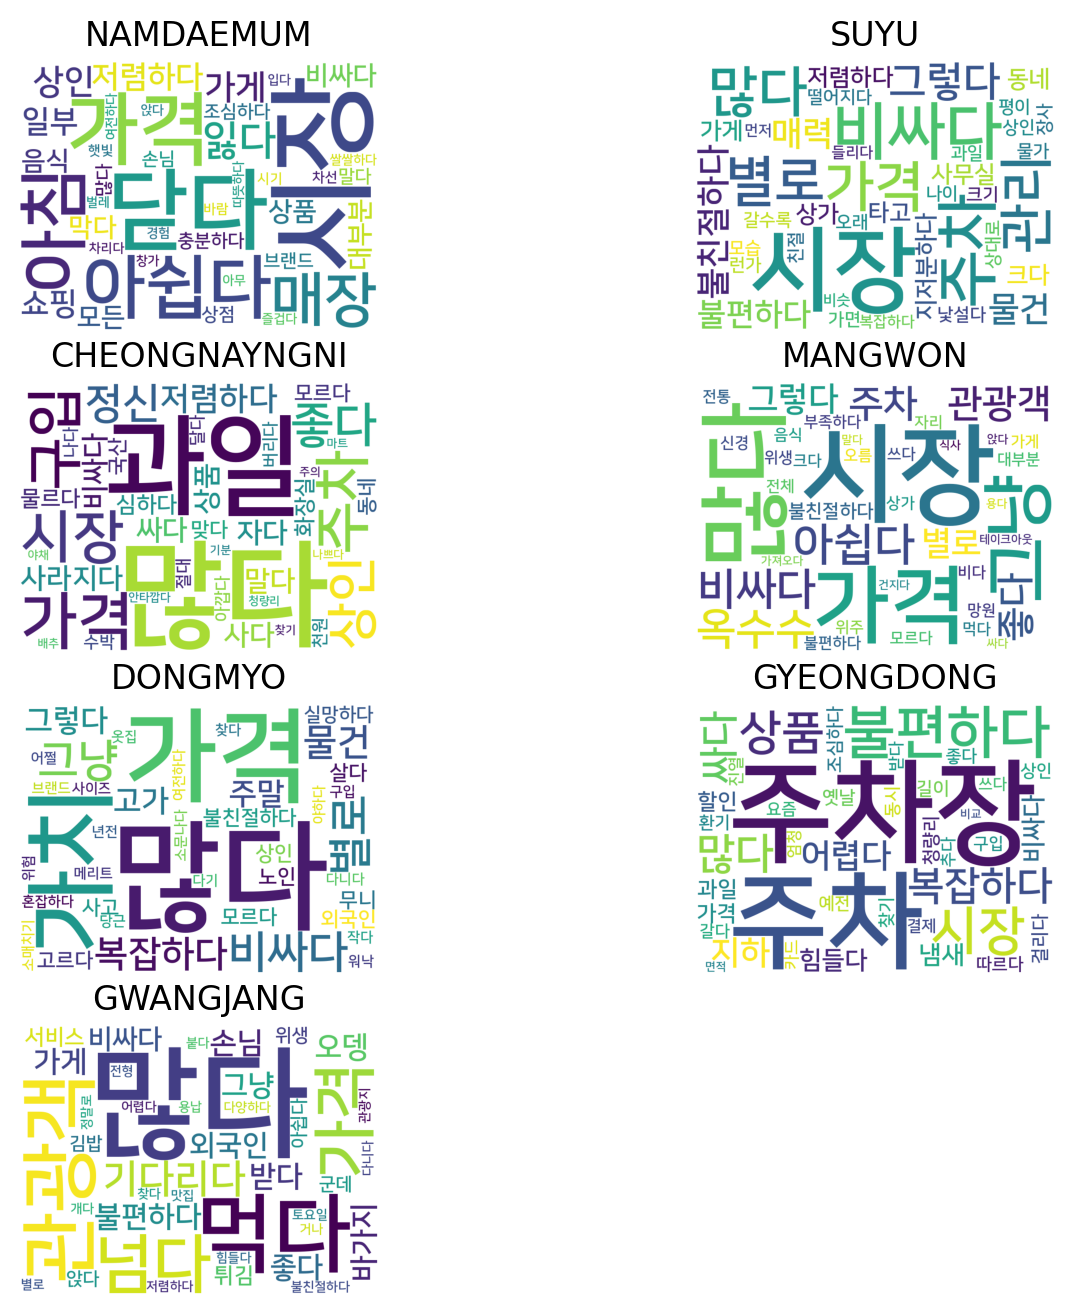

In [ ]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
stop_wds = ['이다', '매우', '너무', '되어다', '싶다', '아주', '없이', '유시', '보다','다녀오다','가다','오다','정말','가보다','들다','많이']

for idx, market in enumerate(df['시장'].unique()):
  result = []
  title_list = df[(df['시장']==market)&(df['sentiment']=='negative')]['content_list']
  for seq in title_list:
    for s in seq:
        if s not in stop_wds:
            result.append(s)

  globals()['tags_%d'%idx] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%idx] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('NAMDAEMUM')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('SUYU')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('CHEONGNAYNGNI')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('MANGWON')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('DONGMYO')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('GYEONGDONG')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('GWANGJANG')


plt.show()

## '종합' 같은 키워드는 topic을 불문하고 다수 등장하는 것으로 보아, 추가적인 처리가 필요해보임

### 시장별 중립워드클라우드

[('많다', 16), ('방문', 15), ('음식', 14), ('시장', 14), ('한국', 11), ('찾다', 10), ('구입', 8), ('물건', 7), ('먹다', 7), ('가격', 6), ('모든', 6), ('서울', 6), ('의류', 5), ('기념품', 5), ('길거리', 5), ('상점', 5), ('말다', 5), ('갈치', 5), ('좋다', 4), ('쇼핑', 4), ('건물', 4), ('아침', 4), ('식사', 4), ('맛보다', 4), ('도시', 4), ('상품', 3), ('관광객', 3), ('거리', 3), ('지역', 3), ('위해', 3), ('가게', 3), ('사르다', 3), ('양말', 3), ('구매', 3), ('사다', 3), ('경험', 3), ('전통', 3), ('고등어', 3), ('호떡', 3), ('분위기', 3)]
[('시장', 13), ('많다', 10), ('수유', 7), ('재래시장', 6), ('전통', 5), ('가게', 5), ('크다', 5), ('튀김', 4), ('쇼핑', 4), ('주차', 4), ('파란색', 4), ('먹다', 3), ('다양하다', 3), ('홍어', 3), ('주차장', 3), ('이벤트', 3), ('대창', 3), ('굽다', 3), ('가끔', 2), ('살다', 2), ('먹거리', 2), ('족발', 2), ('카드', 2), ('김치', 2), ('무치다', 2), ('손님', 2), ('포장마차', 2), ('반찬', 2), ('구매', 2), ('판매', 2), ('갈다', 2), ('상인', 2), ('곱창', 2), ('붉다', 2), ('공영', 2), ('구경', 1), ('간단하다', 1), ('식사', 1), ('강북', 1), ('친구', 1)]
[('시장', 24), ('과일', 16), ('청과', 11), ('많다', 9), ('구입', 6), ('확인', 6), ('가격', 5), ('방문', 5)

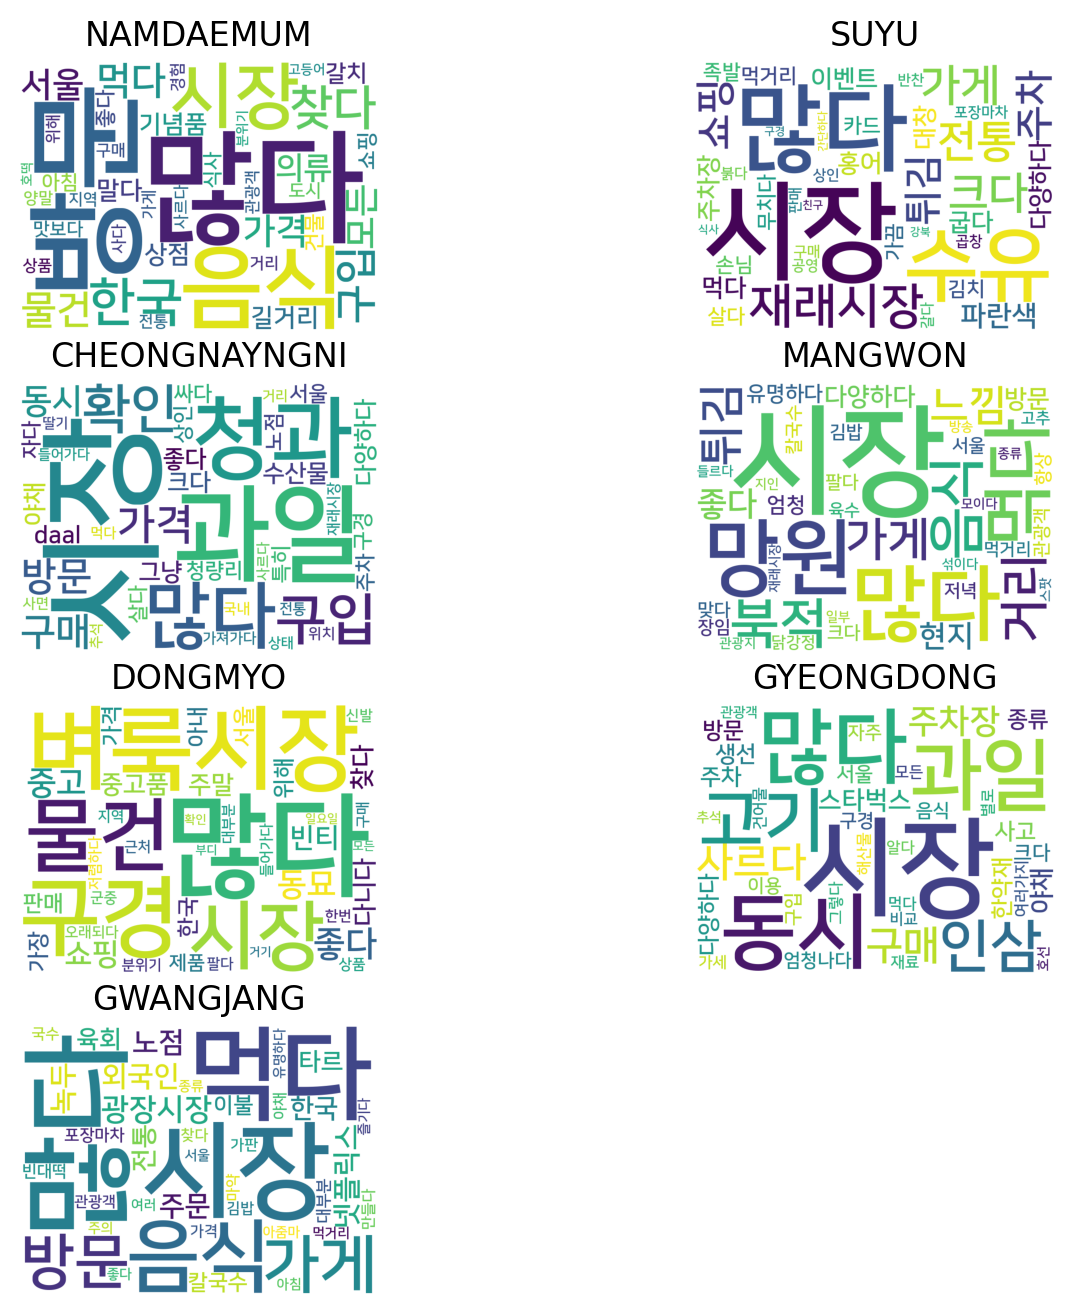

In [ ]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
stop_wds = ['이다', '매우', '너무', '되어다', '싶다', '아주', '없이', '유시', '보다','다녀오다','가다','오다','정말','가보다','들다','많이']

for idx, market in enumerate(df['시장'].unique()):
  result = []
  title_list = df[(df['시장']==market)&(df['sentiment']=='neutral')]['content_list']
  for seq in title_list:
    for s in seq:
        if s not in stop_wds:
            result.append(s)

  globals()['tags_%d'%idx] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%idx] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('NAMDAEMUM')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('SUYU')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('CHEONGNAYNGNI')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('MANGWON')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('DONGMYO')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('GYEONGDONG')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('GWANGJANG')


plt.show()

## '종합' 같은 키워드는 topic을 불문하고 다수 등장하는 것으로 보아, 추가적인 처리가 필요해보임

### 시장별 중립워드클라우드 w. 추가 불용어처리
- 중립워드클라우드의 해석을 용이하게 하기 위해서 문장사이에 있으면 의미가 있는 단어지만 떼어보면 의미를 확실히 파악할 수 없는 단어 존재
- 추가적인 불용어로 처리함

[('음식', 14), ('물건', 7), ('가격', 6), ('모든', 6), ('의류', 5), ('기념품', 5), ('길거리', 5), ('상점', 5), ('갈치', 5), ('좋다', 4), ('쇼핑', 4), ('건물', 4), ('아침', 4), ('식사', 4), ('맛보다', 4), ('도시', 4), ('상품', 3), ('관광객', 3), ('거리', 3), ('지역', 3), ('양말', 3), ('사다', 3), ('경험', 3), ('전통', 3), ('고등어', 3), ('호떡', 3), ('분위기', 3), ('골목', 3), ('사진', 3), ('노점', 3), ('액세서리', 3), ('출구', 3), ('조림', 3), ('보석', 2), ('매점', 2), ('팔찌', 2), ('제품', 2), ('비교', 2), ('팔고', 2), ('느낌', 2)]
[('재래시장', 6), ('전통', 5), ('크다', 5), ('튀김', 4), ('쇼핑', 4), ('주차', 4), ('파란색', 4), ('다양하다', 3), ('홍어', 3), ('주차장', 3), ('이벤트', 3), ('대창', 3), ('굽다', 3), ('가끔', 2), ('살다', 2), ('먹거리', 2), ('족발', 2), ('카드', 2), ('김치', 2), ('무치다', 2), ('손님', 2), ('포장마차', 2), ('반찬', 2), ('판매', 2), ('갈다', 2), ('상인', 2), ('곱창', 2), ('붉다', 2), ('공영', 2), ('구경', 1), ('간단하다', 1), ('식사', 1), ('강북', 1), ('친구', 1), ('저녁', 1), ('물건', 1), ('가격', 1), ('차이', 1), ('사무실', 1), ('근처', 1)]
[('과일', 16), ('청과', 11), ('가격', 5), ('수산물', 4), ('좋다', 4), ('다양하다', 4), ('그냥', 4), ('야채', 4), (

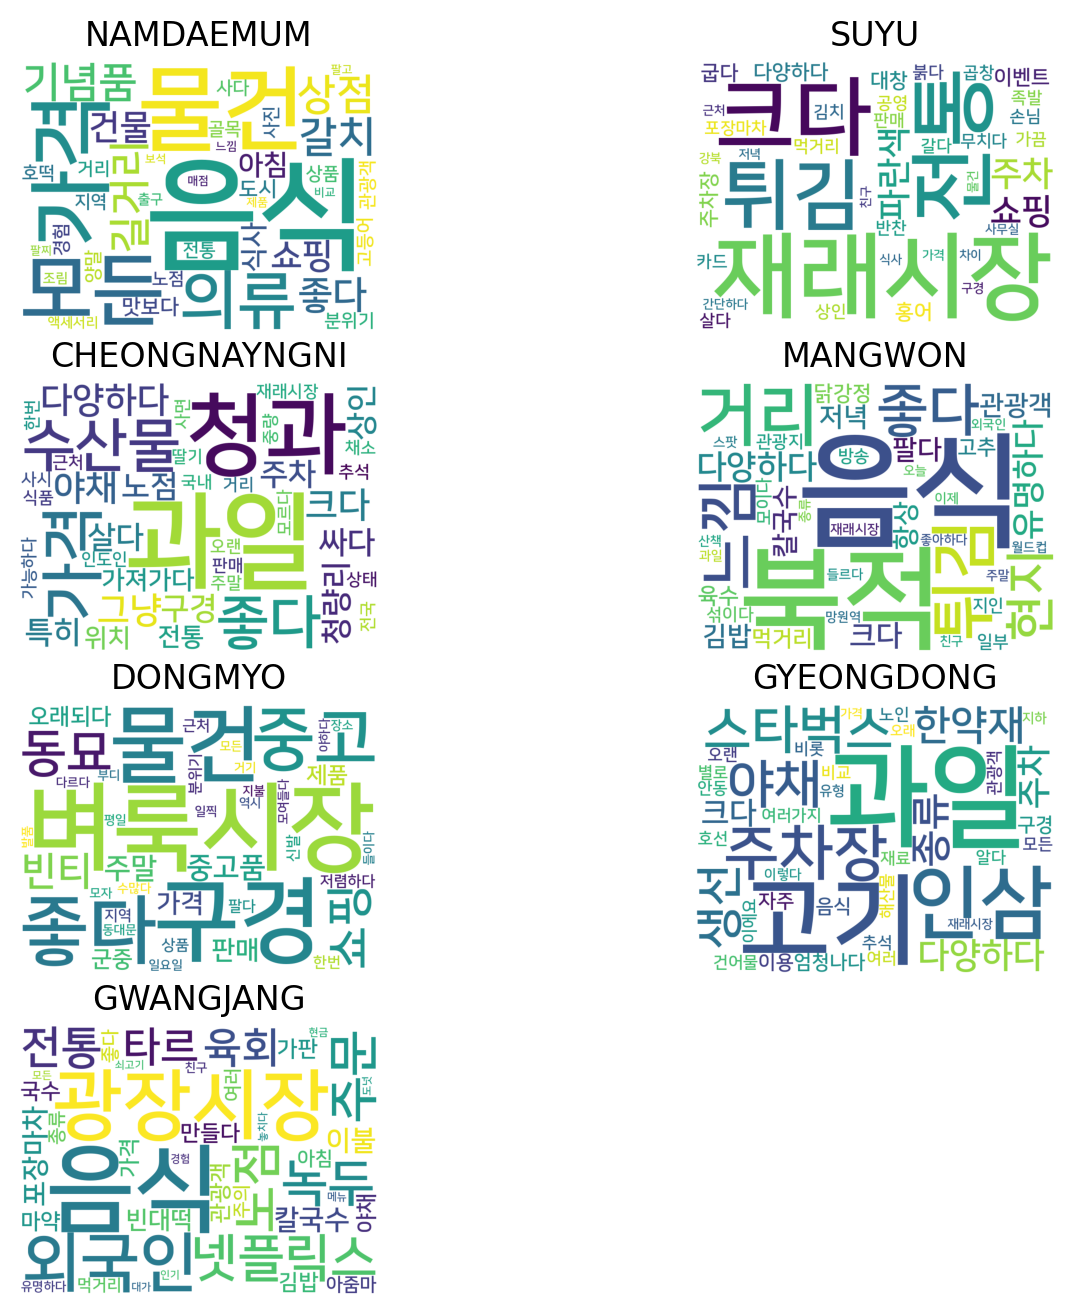

In [ ]:
# 변수 동적 할당 (아래 밑줄 에러 무시)
stop_wds = ['이다', '매우', '너무', '되어다', '싶다', '아주', '없이', '유시', '보다','다녀오다','가다','오다','정말','가보다','들다','많이']
extra = ['구입','수유','광장','망원','남대문시장','말다','다니다','보고','둘러보다','한국','엄청','daal','들어가다','위해','가장','사고','그렇다','나오다','가세','사르다','한국','먹다','많다','시장','찾다','방문','가게','자다','동시','확인','맞다','장임','서울','아내','구매','대부분','즐기다']
stop_wds = stop_wds+extra

for idx, market in enumerate(df['시장'].unique()):
  result = []
  title_list = df[(df['시장']==market)&(df['sentiment']=='neutral')]['content_list']
  for seq in title_list:
    for s in seq:
        if s not in stop_wds:
            result.append(s)

  globals()['tags_%d'%idx] = Counter(result).most_common(40)
  globals()['tags_keys_%d'%idx] = [key for key, _ in Counter(result).most_common(20)]

print(tags_0)
print(tags_1)
print(tags_2)
print(tags_3)
print(tags_4)
print(tags_5)
print(tags_6)


cloud_0 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_0))
cloud_1 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_1))
cloud_2 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_2))
cloud_3 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_3))
cloud_4 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_4))
cloud_5 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_5))
cloud_6 = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate_from_frequencies(dict(tags_6))

plt.figure(figsize = (8, 8))

plt.subplot(4, 2, 1)
plt.imshow(cloud_0)
plt.axis("off")
plt.title('NAMDAEMUM')

plt.subplot(4, 2, 2)
plt.imshow(cloud_1)
plt.axis("off")
plt.title('SUYU')

plt.subplot(4, 2, 3)
plt.imshow(cloud_2)
plt.axis("off")
plt.title('CHEONGNAYNGNI')

plt.subplot(4, 2, 4)
plt.imshow(cloud_3)
plt.axis("off")
plt.title('MANGWON')

plt.subplot(4, 2, 5)
plt.imshow(cloud_4)
plt.axis("off")
plt.title('DONGMYO')

plt.subplot(4, 2, 6)
plt.imshow(cloud_5)
plt.axis("off")
plt.title('GYEONGDONG')

plt.subplot(4, 2, 7)
plt.imshow(cloud_6)
plt.axis("off")
plt.title('GWANGJANG')


plt.show()

## '종합' 같은 키워드는 topic을 불문하고 다수 등장하는 것으로 보아, 추가적인 처리가 필요해보임